This code produces a RKHS approximation of a given function using Gaussian kernel functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def is_scalar(x):
    return np.isscalar(x) or (isinstance(x, np.ndarray) and x.ndim == 0)

class GaussianKernel:
    # even Gaussian kernel function
    def __init__(self, bandwidth=1.0):
        self.bandwidth = float(bandwidth)
        self._sigma_squared = self.bandwidth**2

    def compute_kernel_matrix(self, x):
        # computes K(x_i,x_j)
        x = np.asarray(x, dtype=float)
        X1 = x[:, None]
        X2 = x[None, :]
        sq  = (X1 - X2)**2
        sym = (X1 + X2)**2
        return np.exp(-sq/(2*self._sigma_squared)) + np.exp(-sym/(2*self._sigma_squared))

    def compute_kernel_vector(self, x, x_train):
        # computes K(x, x_j)
        x_train = np.asarray(x_train, dtype=float)
        sq  = (x - x_train)**2
        sym = (x + x_train)**2
        return np.exp(-sq/(2*self._sigma_squared)) + np.exp(-sym/(2*self._sigma_squared))

    def __call__(self, x1, x2):
        return self.compute_kernel_vector(x1, [x2])[0]

class RKHSApproximation:
    
    def __init__(self, kernel, regularization=1e-10):
        self.kernel = kernel
        self.regularization = regularization
        self.x_train = None
        self.alpha   = None
        self.K       = None

    def fit_regular(self, f, x_train):
        # fitting procedure using numpy's linalg.solve
        self.x_train = np.asarray(x_train, dtype=float)
        
        # build matrix from GaussianKernel
        self.K = self.kernel.compute_kernel_matrix(self.x_train)
        K_reg = self.K + self.regularization * np.eye(len(self.K)) # regularization for numerical stability
        # Solve system for coefficients
        y_train = np.asarray([f(xi) for xi in self.x_train], dtype=float)
        self.alpha = np.linalg.solve(K_reg, y_train)

        return self
    
    def fit_least_squares(self, f, x_train):
        # fitting procedure using numpy's linalg.lstsq
        self.x_train = np.asarray(x_train, dtype=float)
        
        # build matrix from GaussianKernel
        self.K = self.kernel.compute_kernel_matrix(self.x_train)
        y_train = np.asarray([f(xi) for xi in self.x_train], dtype=float)
        # least‑squares minimizes ||Ka - y||^2
        # numpy's linalg.lstsq returns a tuple with the first element the coefficients
        self.alpha, *_ = np.linalg.lstsq(self.K, y_train, rcond=None)
        
        return self

    def _eval_single(self, x):
        # return sum
        k_vec = self.kernel.compute_kernel_vector(x, self.x_train)
        return np.dot(k_vec, self.alpha)

    def __call__(self, x):
        x_arr = np.asarray(x, dtype=float)
        if self.alpha is None:
            raise ValueError("Model must be fitted first")
        if is_scalar(x_arr):
            return self._eval_single(x_arr)
        else:
            return np.array([self._eval_single(xi) for xi in x_arr], dtype=float)

    def get_coefficients(self):
        return self.alpha

    def get_kernel_matrix(self):
        return self.K

Fitting regular RKHS model...
Fitting least squares RKHS model...
Plotting functions vs. approximation...


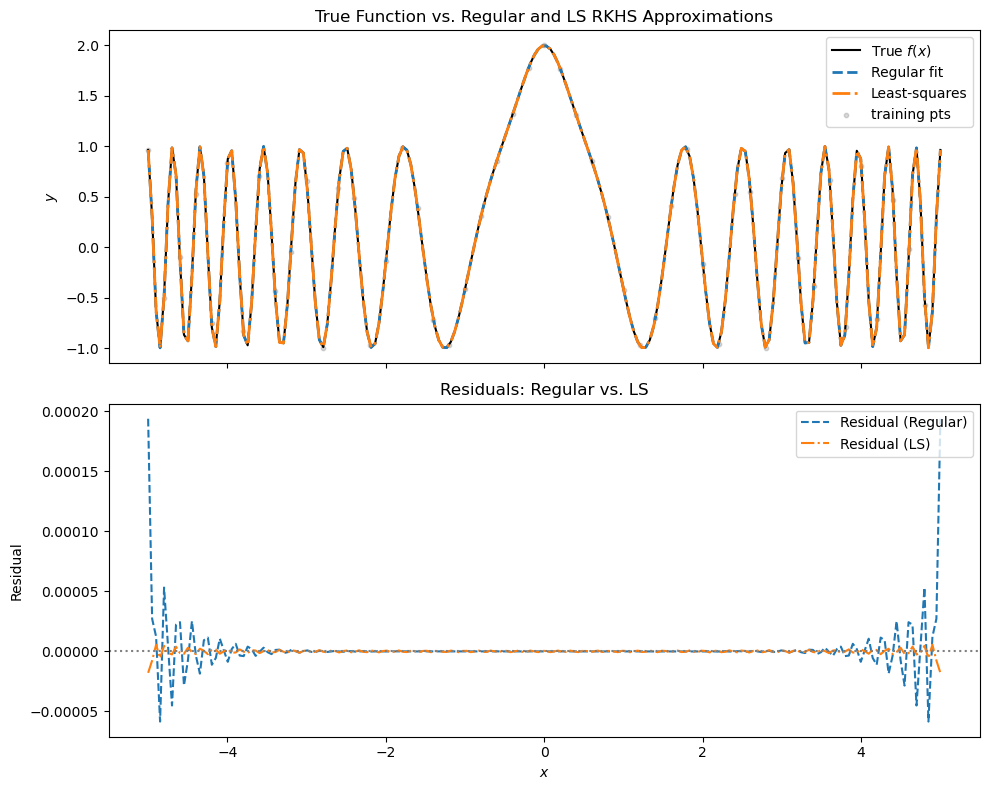

In [7]:
def target_function(x):
    return np.exp(-2*np.pi*np.abs(x)**2) + cos(2*x**2)

n_points = 2500
x_min, x_max = -5, 5
x_train = np.linspace(x_min, x_max, n_points)

bandwidth = 0.2
regularization = 1e-8
kernel = GaussianKernel(bandwidth=bandwidth)
rkhs_reg = RKHSApproximation(kernel, regularization=regularization) # regular kernel variable
rkhs_ls = RKHSApproximation(kernel, regularization=regularization); # least squares kernel variable

print("Fitting regular RKHS model...")
rkhs_reg.fit_regular(target_function, x_train)

print("Fitting least squares RKHS model...")
rkhs_ls.fit_least_squares(target_function, x_train)

n_eval = 200
x_eval = np.linspace(x_min, x_max, n_eval)

print("Plotting functions vs. approximation...")
# compute the true function, RKHS approximation, and residual on x_eval
y_true = target_function(x_eval)
y_reg = rkhs_reg(x_eval) # calls __call__
y_ls = rkhs_ls(x_eval) 
res_reg = y_true - y_reg
res_ls = y_true - y_ls

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top: true vs both approximations
ax1.plot(x_eval, y_true, label="True $f(x)$", color='k')
ax1.plot(x_eval, y_reg, '--', label="Regular fit", linewidth=2)
ax1.plot(x_eval, y_ls, '-.', label="Least‐squares", linewidth=2)
ax1.scatter(x_train[::50],
            target_function(x_train)[::50],
            color='gray', s=10, alpha=0.3, label="training pts")
ax1.set_ylabel("$y$")
ax1.set_title("True Function vs. Regular and LS RKHS Approximations")
ax1.legend(loc="upper right")

# Bottom: residuals of each model
ax2.plot(x_eval, res_reg, '--', label="Residual (Regular)")
ax2.plot(x_eval, res_ls,  '-.', label="Residual (LS)")
ax2.axhline(0, color='gray', linestyle=':')
ax2.set_xlabel("$x$")
ax2.set_ylabel("Residual")
ax2.set_title("Residuals: Regular vs. LS")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()